In [146]:
"""
Created on Tuesday 1 May 2023
Author: ZAW
"""
#import libraries
import numpy as np
import pandas as pd
import os
from scipy.optimize import curve_fit
import warnings
warnings.simplefilter("ignore")

### Load the subject and stiumuls repect to their speed
path = os.getcwd()
dirname = os.path.dirname(path)
# for HC
data_file = 'data/eight_degHC.csv'
# # for PD
#data_file = 'data/PD/one_deg.csv'

data_path = os.path.join(dirname,data_file)
# data = pd.read_csv(data_path)
data= pd.read_csv(data_path)

#import CSV data for stimulus
path_sti = os.getcwd()
dirname_sti = os.path.dirname(path_sti)
data_file_sti = 'data/8_degSti.xlsx'
data_path_sti = os.path.join(dirname_sti,data_file_sti)
rawdata = pd.read_excel(data_path_sti)
data_st = np.array(rawdata[1:],dtype=np.float)
time = data_st[:,1]
position = data_st[:,0]

FirstTrialHC = []

# List of subject codes (e.g. PD001, PD002, etc.)

subject_codes = ["PD001","PD002","PD003","PD004","PD005","PD006","PD007","PD008","PD009","PD010",
 "PD011","PD012","PD013","PDN015","PDN017","PDN018","PDN019","PDN022","PD026"]

# subject_codes = ['PD104','PD106','PD107','PD108','PD109','PD111','PD112','PD119','PD120','PD121',
#  'PD122','PD126','PDPY101','PDQE102','PDQE103','PDQE104','PDQE105','PDQE107','PDQE108','PDQE112',
#  'PDQE113','PDQE114','PDQE115','PDPW104','PDPW106','PDPW107','PDPW109','PDPW110','PDPW111','PDPW112',
#  'PDPW113']

for subject_code in subject_codes:
    ### Load the subject and stiumuls repect to their speed
    path = os.getcwd()
    dirname = os.path.dirname(path)
    # for HC
    data_file = 'data/eight_degHC.csv'
    # # for PD
    #data_file = 'data/PD/one_deg.csv'

    data_path = os.path.join(dirname,data_file)
    # data = pd.read_csv(data_path)
    data= pd.read_csv(data_path)
    print('File '+ str(subject_code)+ ' is started.') 
    x_column = f'x1_{subject_code}'
    y_column = f'y1_{subject_code}'

    # Check if both columns exist in the DataFrame before accessing them
    if x_column in data.columns and y_column in data.columns:
        data_hc = data[[x_column, y_column]]
    else:
        print(f"Columns for subject code {subject_code} not found. Skipping...")
        continue

    y_data = data_hc[x_column]
    x_data = data_hc[y_column]

    # data_hc = data[['x1_PD001','y1_PD001']] # change the ID each subject code(e.g PD001 or PD003)
    # y_data = data_hc[data_hc.columns[0]]
    # x_data = data_hc[data_hc.columns[1]]


    # Trigonometric Functions
    # Trigonometric functions

    # Define the function
    def func(x, a, b, c):  #Position as a function of time.
        return a*(2/np.pi)*np.arcsin(np.sin(np.pi*(b*x+c)))

    #initial guesses( This has to change depend on stimulus speed)
    #for 1 degree per second: [10, 0.05, 0]
    #for 2 degrees per second: [10, 0.1, 0]
    #for 4 degrees per second: [10, 0.2, 0]
    #for 6 degrees per second: [10, 0.3, 0]
    #for 8 degrees per second: [10, 0.4, 0]
    InitialGuess = [10, 0.4, 0] # for one degree

    # Perform curve fitting
    popt, pcov = curve_fit(func,position,time, p0=InitialGuess)

    # Extract the optimal values of a, b, and c
    a, b, c = popt
    # print("a =", a)
    # print("b =", b)
    # print("c =", c)

    # Fit the curve
    fit_time = func(y_data,a,b,c)
    # plt.plot(y_data,fit_time)
    # plt.show()

    # Find the residual
    # Different(aka residual)
    diff = x_data - fit_time

    dt_array = np.array(diff)
    dt_array = pd.DataFrame(dt_array,columns=['diff'])
    window_size = 3
    dt_array['Moving_Average'] = dt_array['diff'].rolling(window=window_size).mean()
    #plt.plot(y_data,dt_array['Moving_Average'])
    # create dataframe
    data = {'Time':y_data,'POS':dt_array['Moving_Average']}
    df = pd.DataFrame(data)

    # The whole dataset
    # Plot specific range
    x_start = 1.3
    x_end = 11.6

    # Filter the data points within the disired range using boolean indexing
    mask = (df['Time'] >= x_start) & (df['Time'] <= x_end)
    x_data_range = df.loc[mask]

    data = {'Time':x_data_range['Time'],'POS':x_data_range['POS']}
    df_test = pd.DataFrame(data)

    # Determine the integration window
    def check_sign(x):
        if x > 0:
            return "Positive"
        else:
            return "Negative"
    df_test['Sign'] = df_test['POS'].apply(check_sign)

    # Condition window width 
    def calculate_start_end(row):
        global last_positive, last_negative
        if row['Sign'] == 'Positive':
            if row.name == 0 or df_test.loc[row.name - 1, 'Sign'] != 'Positive':
                last_positive = row['Time']
                return last_positive, '', '', ''
            elif row.name < len(df_test) - 1 and df_test.loc[row.name + 1, 'Sign'] != 'Positive':
                pos_end = row['Time']
                last_positive = ''
                return '', pos_end, '', ''
            else:
                return '', '', '', ''
        elif row['Sign'] == 'Negative':
            if row.name == 0 or df_test.loc[row.name - 1, 'Sign'] != 'Negative':
                last_negative = row['Time']
                return '', '', last_negative, ''
            elif row.name < len(df_test) - 1 and df_test.loc[row.name + 1, 'Sign'] != 'Negative':
                last_negative = row['Time']
                return '', '', '', last_negative
            else:
                return '', '', '', ''
        else:
            return '', '', '', ''

    # Initialize the last positive and negative values to empty strings 
    last_positive = ''
    last_negative = ''

    # Reset the index of the DataFrame
    df_test = df_test.reset_index(drop=True)

    # Apply the custom function to create new columns
    df_test['PosTim_Start'], df_test['PosTim_End'], df_test['NegTim_Start'], df_test['NegTim_End'] = zip(*df_test.apply(calculate_start_end, axis=1))

    # Fill the empty cells with an empty string
    df_test['PosTim_Start'] = df_test['PosTim_Start'].fillna('') 
    df_test['PosTim_End'] = df_test['PosTim_End'].fillna('')
    df_test['NegTim_Start'] = df_test['NegTim_Start'].fillna('')
    df_test['NegTim_End'] = df_test['NegTim_End'].fillna('')

    # Print the resulting dataframe 
    #print(df_test)


    # Positive time start trimming
    # Select the non-empty values in the 'Pos_Start' column
    pos_start_values = df_test.loc[df_test['PosTim_Start'] != '', 'PosTim_Start'].values

    # Round the values in the 'Pos_Start' column to two decimal places
    rounded_pos_start_values = []
    for value in pos_start_values:
        rounded_pos_start_values.append(round(value - 0.003, 2))

    # Convert the list of rounded values back to a NumPy array
    postim_start_values = np.array(rounded_pos_start_values)

    # Print the non-empty values
    #print(postim_start_values)


    # Positive time end triming
    # Select the non-empty values in the 'Pos_End' column
    pos_end_values = df_test.loc[df_test['PosTim_End'] != '', 'PosTim_End'].values

    # Round the values in the 'Pos_End' column to two decimal places
    # rounded_pos_end_values = []
    # for value in pos_end_values:
    #     rounded_pos_end_values.append(round(value - 0.02, 2))

    # Convert the list of rounded values back to a NumPy array
    postim_end_values = np.array(pos_end_values)

    # Print the non-empty values
    #print(postim_end_values)


    # Reload the raw data for mapping
    data = data_hc.rename(columns={data_hc.columns.values[0]:"Position",
                                data_hc.columns.values[1]:'Time'})


    # Map the start positive time to POS in raw data
    # Create a dictionary from the mapping list
    mapping_list = postim_start_values

    # Map the values to the 'POS' column in raw
    mapped_posSt = data.loc[data['Position'].isin(mapping_list),'Time']


    # Map the end positive time to POS in raw data
    # Create a dictionary from the mapping list
    mapping_list = postim_end_values

    # Map the values to the 'POS' column in raw
    mapped_posEnd = data.loc[data['Position'].isin(mapping_list),'Time']


    # Velocity param positive dataframe
    # # column miss match
    # Check lengths and truncate longer column 
    if len(postim_start_values) > len(mapped_posSt): 
        postim_start_values = postim_start_values[:len(mapped_posSt)] 
    elif len(mapped_posSt) > len(postim_start_values):
        mapped_posSt = mapped_posSt[:len(postim_start_values)]      

    # Now columns have equal length 
    data_param = {'positive_x1':postim_start_values,'positive_y1':mapped_posSt}             
    param_vel_start = pd.DataFrame(data_param)

    data_param= {'positive_x2':postim_end_values,'positive_y2':mapped_posEnd}
    param_vel_end = pd.DataFrame(data_param)

    # Reset the indices of the DataFrames
    param_vel_start = param_vel_start.reset_index(drop=True)
    param_vel_end = param_vel_end.reset_index(drop=True)

    # Concatenate the DataFrames horizontally
    param_vel_positive_final = pd.concat([param_vel_start,param_vel_end],axis=1)
    #param_vel_positive_final['Del_X'] = param_vel_positive_final['positive_x2'] - param_vel_positive_final['positive_x1']

    param_vel_positive_final['Del_X'] = (param_vel_positive_final['positive_x2'] - 
                                        param_vel_positive_final['positive_x1']).where(~param_vel_positive_final['positive_x2'].isnull(), np.nan)



    # # Remove short duration SWJ from 50 ms to 400 ms
    param_vel_positive_final = param_vel_positive_final[(param_vel_positive_final['Del_X'] > 0.4) & 
                                                        (param_vel_positive_final['Del_X'] < 2.00)]

    # Conditions
    param_vel_positive_final['Condition'] = param_vel_positive_final['positive_x2'] - param_vel_positive_final['positive_x1']
    param_vel_positive_final['Condition'] =abs(param_vel_positive_final['Condition'])
    param_vel_positive_final = param_vel_positive_final[param_vel_positive_final['Condition'] > 0.72]   

    # iterate over the rows of the dataframe
    prev_positive_x2 = None
    for i, row in param_vel_positive_final.iterrows():
        # check if this is not the first row
        if prev_positive_x2 is not None:
            # check if positive_x1 is lower than the previous positive_x2
            if row['positive_x1'] < prev_positive_x2:
                # remove this row from the dataframe
                param_vel_positive_final = param_vel_positive_final.drop(i)
            else:
                # update prev_positive_x2 if positive_x1 is greater than or equal to prev_positive_x2
                prev_positive_x2 = row['positive_x2']
        else:
            # initialize prev_positive_x2 with the first row value
            prev_positive_x2 = row['positive_x2']


    # Velocity for positive pieak calculation
    # Calculate the difference between y2 and y1 divided by the difference between x2 and x1
    param_vel_positive_final['slope'] = (param_vel_positive_final['positive_y2'] - param_vel_positive_final['positive_y1']) / (param_vel_positive_final['positive_x2'] - param_vel_positive_final['positive_x1'])

    # abs
    param_vel_positive_final['slope'] = abs(param_vel_positive_final['slope'])

    # Reindexing
    param_vel_positive_final = param_vel_positive_final.reset_index(drop=True)

    # Remove unwant values
    #param_gain_positive_final.loc[param_gain_positive_final['slope'] > 1.09, 'slope'] = np.nan  

    # Calculate the average slope
    average_positive_slope = abs(param_vel_positive_final['slope'].mean())

    # Print the average slope
    #print(average_positive_slope)


    # Negative time start trimming
    # Select the non-empty values in the 'Pos_Start' column
    neg_start_values = df_test.loc[df_test['NegTim_Start'] != '', 'NegTim_Start'].values

    # Round the values in the 'Pos_Start' column to two decimal places
    # rounded_neg_start_values = []
    # for value in neg_start_values:
    #     rounded_neg_start_values.append(round(value - 0.003, 2))

    # Convert the list of rounded values back to a NumPy array
    negtim_start_values = np.array(neg_start_values)

    # Print the non-empty values
    #print(negtim_start_values)


    # Negative Time End Triming
    # Select the non-empty values in the 'Pos_Start' column
    neg_end_values = df_test.loc[df_test['NegTim_End'] != '', 'NegTim_End'].values

    # Round the values in the 'Pos_Start' column to two decimal places
    # rounded_neg_end_values = []
    # for value in neg_end_values:
    #     rounded_neg_end_values.append(round(value - 0.02, 2))

    # Convert the list of rounded values back to a NumPy array
    negtim_end_values = np.array(neg_end_values)


    # Map the start negative time to POS in raw data
    # Create a dictionary from the mapping list
    mapping_list = negtim_start_values

    # Map the values to the 'POS' column in raw
    mapped_negSt = data.loc[data['Position'].isin(mapping_list),'Time']



    # Ma the end of negative time to pos in raw data
    # Create a dictionary from the mapping list
    mapping_list = negtim_end_values

    # Map the values to the 'POS' column in raw
    mapped_negEnd = data.loc[data['Position'].isin(mapping_list),'Time']


    # Velocity param negative datafrmae
    # column miss match
    # Check lengths and truncate longer column 
    if len(negtim_start_values) > len(mapped_negSt): 
        negtim_start_values = negtim_start_values[:len(mapped_negSt)] 
    elif len(mapped_negSt) > len(negtim_start_values):
        mapped_negSt = mapped_negSt[:len(negtim_start_values)]  


    data_param = {'negative_x1':negtim_start_values,'negative_y1':mapped_negSt}             
    param_vel_start = pd.DataFrame(data_param)
    data_param= {'negative_x2':negtim_end_values,'negative_y2':mapped_negEnd}
    param_vel_end = pd.DataFrame(data_param)

    # Reset the indices of the DataFrames
    param_vel_start = param_vel_start.reset_index(drop=True)
    param_vel_end = param_vel_end.reset_index(drop=True)

    # Concatenate the DataFrames horizontally
    param_vel_negative_final = pd.concat([param_vel_start,param_vel_end],axis=1)
    param_vel_negative_final['Del_X'] = param_vel_negative_final['negative_x2'] - param_vel_negative_final['negative_x1']
    #param_vel_negative_final = param_vel_negative_final.fillna(method='ffill')
    #param_vel_negative_final

    # Remove short duration
    # param_vel_negative_final = param_vel_negative_final[(param_vel_negative_final['Del_X'] > 0.3) & 
    #                                                     (param_vel_negative_final['Del_X'] < 2.07)]
    param_vel_negative_final = param_vel_negative_final[param_vel_negative_final['Del_X'] < 2.07]
    #                                                     
    param_vel_negative_final['Del_X'] = (param_vel_negative_final['negative_x2'] - 
                                        param_vel_negative_final['negative_x1']).where(~param_vel_negative_final['negative_x2'].isnull(), np.nan)



    # # Remove short duration SWJ from 50 ms to 400 ms
    param_vel_negative_final = param_vel_negative_final[(param_vel_negative_final['Del_X'] > 0.4) & 
                                                        (param_vel_negative_final['Del_X'] < 2.00)]


    # iterate over the rows of the dataframe
    prev_negative_x2 = None
    for i, row in param_vel_negative_final.iterrows():
        # check if this is not the first row
        if prev_negative_x2 is not None:
            # check if positive_x1 is lower than the previous positive_x2
            if row['negative_x1'] < prev_negative_x2:
                # remove this row from the dataframe
                param_vel_negative_final = param_vel_negative_final.drop(i)
            else:
                # update prev_positive_x2 if positive_x1 is greater than or equal to prev_positive_x2
                prev_megatove_x2 = row['negative_x2']
        else:
            # initialize prev_positive_x2 with the first row value
            prev_negative_x2 = row['negative_x2']

    # Velocity for Negative peak calculation
    # Calculate the difference between y2 and y1 divided by the difference between x2 and x1
    param_vel_negative_final['slope'] = (param_vel_negative_final['negative_y2']
                                        - param_vel_negative_final['negative_y1']) / (param_vel_negative_final['negative_x2'] 
                                        - param_vel_negative_final['negative_x1'])

    # abs
    param_vel_negative_final['slope'] = abs(param_vel_negative_final['slope'])

    param_vel_negative_final['slope'].replace([np.inf, -np.inf], np.nan, inplace=True)

    # Reindexing
    param_vel_negative_final = param_vel_negative_final.reset_index(drop=True)

    # Remove unwant values
    # param_vel_negative_final.loc[(param_vel_negative_final['slope'] < 0.80) |  
    #                              (param_vel_negative_final['slope'] > 1.09), 
    #                              'slope'] = np.nan
    # Calculate the average slope
    average_negative_slope = abs(param_vel_negative_final['slope'].mean())

    # Print the average slope
    #print(average_negative_slope)


    # Total velocity for both positive and negative
    Final_Vel = pd.concat([param_vel_positive_final[['Del_X','slope']],
                        param_vel_negative_final[['Del_X','slope']]], axis=0, join='outer')

    try: 
        # Counter chck with duration and velocity
        Final_Vel['Checked_velocity'] = Final_Vel['slope'] * Final_Vel['Del_X']
        Vel = Final_Vel['Checked_velocity'].sum()/Final_Vel['Del_X'].sum()

        # Calculate gain
        speed = 6 # stimulus speed
        total_gain = Vel/speed
    except ZeroDivisionError:
        #print("The gain for this subject is:",total_gain)
        result = {"SubjectID":subject_code ,"gain":total_gain}
        FirstTrialHC.append(result)
        print('File '+ str(subject_code)+ ' is done.') 

# Create a DataFrame from the list of dictionaries
FirstTrialHC = pd.DataFrame(FirstTrialHC)
FirstTrialHC.to_csv('EightFirstTrialHC.csv',index=False)
print(FirstTrialHC)


File PD001 is started.
File PD002 is started.
File PD003 is started.
File PD004 is started.
File PD005 is started.
File PD006 is started.
File PD007 is started.
File PD008 is started.
File PD009 is started.
File PD010 is started.
File PD011 is started.
File PD012 is started.
File PD012 is done.
File PD013 is started.
File PDN015 is started.
File PDN017 is started.
File PDN018 is started.
File PDN019 is started.
File PDN022 is started.
Columns for subject code PDN022 not found. Skipping...
File PD026 is started.
  SubjectID      gain
0     PD012  1.288182


In [158]:
# HC

# Read the CSV files
FirstTrialHC = pd.read_csv('EightFirstTrialHC.csv')

# Rename the 'Gain' column in the first DataFrame to avoid confusion
FirstTrialHC = FirstTrialHC.rename(columns={'gain': 'gain1'})

SecondTrialHC = pd.read_csv('EightSecondTrialHC.csv')
SecondTrialHC = SecondTrialHC.rename(columns={'gain': 'gain2'})

# Combine the DataFrames side by side
Total_HC = pd.concat([FirstTrialHC.set_index('SubjectID'), SecondTrialHC.set_index('SubjectID')], axis=1)

# Calculate the average gain for each row, ignoring NaN values
Total_HC['AutoGain'] = Total_HC[['gain1', 'gain2']].apply(lambda x: np.nanmean(x), axis=1)

# Reset the index and save the combined DataFrame to a new CSV file
Total_HC.reset_index().to_csv('EightHCAverageGain.csv', index=False)

In [159]:
Total_HC

,gain1,gain2,AutoGain
SubjectID,,,
PD012,1.288182,0.624718,0.956450
PD001,NaN,0.000000,0.000000
PD002,NaN,0.163704,0.163704
PD003,NaN,0.296948,0.296948
PD004,NaN,0.183092,0.183092
PD005,NaN,1.069287,1.069287
PD006,NaN,0.464272,0.464272
PD007,NaN,0.392532,0.392532
PD008,NaN,0.000000,0.000000


In [160]:
# PD

# Read the CSV files
FirstTrialPD = pd.read_csv('EightFirstTrialPD.csv')

# Rename the 'Gain' column in the first DataFrame to avoid confusion
FirstTrialPD = FirstTrialPD.rename(columns={'gain': 'gain1'})

SecondTrialPD = pd.read_csv('EightSecondTrialPD.csv')
# Rename the 'Gain' column in the first DataFrame to avoid confusion
SecondTrialPD = SecondTrialPD.rename(columns={'gain': 'gain2'})

# Combine the DataFrames side by side
Total_PD = pd.concat([FirstTrialPD.set_index('SubjectID'), SecondTrialPD.set_index('SubjectID')], axis=1)

# Calculate the average gain for each row, ignoring NaN values
Total_PD['AutoGain'] = Total_PD[['gain1', 'gain2']].apply(lambda x: np.nanmean(x), axis=1)

# Reset the index and save the combined DataFrame to a new CSV file
Total_PD.reset_index().to_csv('EightPDAverageGain.csv', index=False)

In [161]:
Total_PD

,gain1,gain2,AutoGain
SubjectID,,,
PD104,1.116738,NaN,1.116738
PD106,1.490556,NaN,1.490556
PD107,0.529086,NaN,0.529086
PD108,1.334918,NaN,1.334918
PD109,1.278639,NaN,1.278639
PD111,1.241435,NaN,1.241435
PD112,1.227190,NaN,1.227190
PD119,1.227591,NaN,1.227591
PD120,0.309758,NaN,0.309758


In [162]:
# Combine the DataFrames
EightHCPD = pd.concat([Total_HC, Total_PD], axis=0)

In [163]:
print(len(EightHCPD.index))

49


### Manual

In [164]:
manual_ID = EightHCPD.index
manual_values = [0.73848261,
0.986636423,
0.745501748,
0.7579907,
0.909797906,
0.78105301,
0.858659788,
0.85951671,
0.885411917,
0.828367438,
0.911980105,
0.863014297,
0.708399551,
0.857059114,
0.789595449,
0.894818095,
1.062361214,
0.811056814,


0.768461692,
0.889365304,
0.732299908,
0.80410417,
0.614253632,
1.086722755,
0.768287138,
0.624113864,
0.874898474,
0.777961479,
0.877308815,
0.799197517,
0.730673411,
0.840238835,
0.743815855,
0.634293751,
0.529398709,
0.750469831,
0.74858958,
0.881237282,
0.750773553,
0.789284873,
0.972603229,
0.684932294,
0.795542508,
0.653688664,
0.909587046,
0.570216915,
0.470689666,
0.816745486,
0.796820748,

]
manual_gain = pd.DataFrame({'SubjectID':manual_ID, "ManualGain":manual_values})
manual_gain.set_index('SubjectID', inplace=True)

## Compare

In [165]:
ComEightHCPD = pd.concat([EightHCPD, manual_gain], axis=1)
ComEightHCPD = ComEightHCPD.drop(['gain1','gain2'],axis=1)

ComEightHCPD['Difference'] = ComEightHCPD['AutoGain'] - ComEightHCPD['ManualGain']
ComEightHCPD.to_csv('ComEightHCPD.csv')
print(ComEightHCPD)

print("The mean difference",ComEightHCPD['Difference'].mean())

           AutoGain  ManualGain  Difference
SubjectID                                  
PD012      0.956450    0.738483    0.217968
PD001      0.000000    0.986636   -0.986636
PD002      0.163704    0.745502   -0.581798
PD003      0.296948    0.757991   -0.461043
PD004      0.183092    0.909798   -0.726706
PD005      1.069287    0.781053    0.288234
PD006      0.464272    0.858660   -0.394388
PD007      0.392532    0.859517   -0.466985
PD008      0.000000    0.885412   -0.885412
PD009      1.177500    0.828367    0.349133
PD010      0.674050    0.911980   -0.237930
PD011      0.534242    0.863014   -0.328773
PD013      0.519578    0.708400   -0.188822
PDN015     0.268604    0.857059   -0.588455
PDN017     0.592215    0.789595   -0.197381
PDN018     0.668373    0.894818   -0.226445
PDN019     0.135254    1.062361   -0.927107
PD026      0.363779    0.811057   -0.447278
PD104      1.116738    0.768462    0.348277
PD106      1.490556    0.889365    0.601190
PD107      0.529086    0.732300 

### Correlation plot

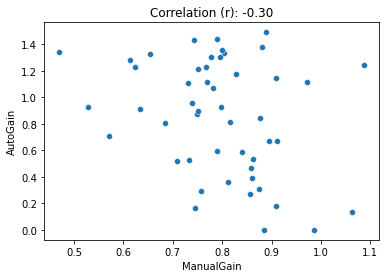

In [166]:
correlation_coef = ComEightHCPD['ManualGain'].corr(ComEightHCPD['AutoGain'])
# Create scatter plot
import seaborn as sns
import matplotlib.pyplot as plt
plot = sns.scatterplot(x='ManualGain', y='AutoGain', data=ComEightHCPD)
plot.set_title(f'Correlation (r): {correlation_coef:.2f}')

# Display the plot
plt.show()

In [333]:
One = pd.read_csv("ComOneHCPD.csv")
Two = pd.read_csv("ComTwoHCPD.csv")
Four = pd.read_csv("ComFourHCPD.csv")
Six = pd.read_csv("ComSixHCPD.csv")
Eight = pd.read_csv("ComEightHCPD.csv")
AllSpeed = pd.concat([One, Two, Four, Six, Eight],axis=0)

In [350]:
One

,SubjectID,AutoGain,ManualGain,Difference
0,PD001,0.925939,0.912073,0.013866
1,PD002,0.902734,0.913615,-0.010882
2,PD003,0.985709,0.946453,0.039256
3,PD004,1.064557,0.930324,0.134233
4,PD005,0.951542,1.024160,-0.072618
5,PD006,0.935256,0.860240,0.075016
6,PD007,0.940150,0.964705,-0.024555
7,PD008,0.961614,0.926124,0.035489
8,PD009,0.878762,0.968895,-0.090133
9,PD010,0.961301,0.971484,-0.010183


In [354]:
import statistics
# Create a list of dictionaries containing the data
data_list = [One, Two, Four, Six, Eight]

# Create an empty dataframe to store the results
results_df = pd.DataFrame(columns=['SubjectID', 'Standard deviation'])

# Iterate over the range of indices from 0 to 48
for i in range(49):
    # Create a list of values for the current index from each dictionary
    values = [d['AutoGain'][i] for d in data_list]
    # Calculate the standard deviation of the values
    std_dev = statistics.stdev(values)
    # Print the index and standard deviation
    #print(One['SubjectID'][i], "Standard deviation:", std_dev)
    results_df = results_df.append({'SubjectID': One['SubjectID'][i], 'Standard deviation': std_dev}, ignore_index=True)
# Save the results dataframe to an Excel file
results_df.to_excel('results.xlsx', index=False)

In [343]:
import statistics
statistics.stdev([One['AutoGain'][0],Two['AutoGain'][0], Four['AutoGain'][0],Six['AutoGain'][0],Eight['AutoGain'][0]])

0.043075282814873835

In [332]:
One['AutoGain'][0]

0.9094693861986128

In [342]:
One

,SubjectID,AutoGain,ManualGain,Difference
0,PD001,0.925939,0.912073,0.013866
1,PD002,0.902734,0.913615,-0.010882
2,PD003,0.985709,0.946453,0.039256
3,PD004,1.064557,0.930324,0.134233
4,PD005,0.951542,1.024160,-0.072618
5,PD006,0.935256,0.860240,0.075016
6,PD007,0.940150,0.964705,-0.024555
7,PD008,0.961614,0.926124,0.035489
8,PD009,0.878762,0.968895,-0.090133
9,PD010,0.961301,0.971484,-0.010183


In [330]:
One['AutoGain'][17]

0.7312754164005961

### STD For HC(One)

In [234]:
# For HC
Stdev = pd.read_csv('OneHCAverageGain.csv')
Stdev['STDEV'] = np.std(Stdev['AutoGain'])
print(Stdev['STDEV'].mean())

0.06776462580511375


### Check HC one degree

In [289]:
OneHC= pd.read_csv('ComOneHCPD.csv')
OneHC = OneHC[0:18]

In [290]:
# Calculate the absolute difference between the values in column1 and column2
diff = abs(OneHC['Difference'])

# Filter the DataFrame to include only the rows where the difference is greater than or less than a specific value
out_of_range = OneHC[(diff > 0.06) | (diff < -0.06)]

# Print the out-of-range rows
if len(out_of_range) > 0:
    print("The following rows have values that are not within STDEV:")
    print(out_of_range)
else:
    print("All values in column1 and column2 are within STDEV.")

The following rows have values that are not within STDEV:
   SubjectID  AutoGain  ManualGain  Difference
3      PD004  1.064557    0.930324    0.134233
4      PD005  0.951542    1.024160   -0.072618
5      PD006  0.935256    0.860240    0.075016
8      PD009  0.878762    0.968895   -0.090133
13    PDN015  0.741753    0.988454   -0.246700
14    PDN017  1.016066    0.875559    0.140507
16    PDN019  0.898882    1.016500   -0.117618


### STD For HC(Two)

In [235]:
Stdev = pd.read_csv('TwoHCAverageGain.csv')
Stdev['STDEV'] = np.std(Stdev['AutoGain'])
print(Stdev['STDEV'].mean())

0.12334948916436031


### Check for HC two degree

In [273]:
TwoHC= pd.read_csv('ComTwoHCPD.csv')
TwoHC = TwoHC[0:18]

In [291]:
# Calculate the absolute difference between the values in column1 and column2
diff = abs(OneHC['Difference'])

# Filter the DataFrame to include only the rows where the difference is greater than or less than a specific value
out_of_range = OneHC[(diff > 0.12) | (diff < -0.12)]

# Print the out-of-range rows
if len(out_of_range) > 0:
    print("The following rows have values that are not within STDEV:")
    print(out_of_range)
else:
    print("All values in column1 and column2 are within STDEV.")

The following rows have values that are not within STDEV:
   SubjectID  AutoGain  ManualGain  Difference
3      PD004  1.064557    0.930324    0.134233
13    PDN015  0.741753    0.988454   -0.246700
14    PDN017  1.016066    0.875559    0.140507


### STD For HC(Four)

In [275]:
Stdev = pd.read_csv('FourHCAverageGain.csv')
Stdev['STDEV'] = np.std(Stdev['AutoGain'])
print(Stdev['STDEV'].mean())

0.06559128316683789


### Check for HC four

In [292]:
FourHC= pd.read_csv('ComFourHCPD.csv')
FourHC = FourHC[0:18]

In [293]:
# Calculate the absolute difference between the values in column1 and column2
diff = abs(FourHC['Difference'])

# Filter the DataFrame to include only the rows where the difference is greater than or less than a specific value
out_of_range = FourHC[(diff > 0.06) | (diff < -0.06)]

# Print the out-of-range rows
if len(out_of_range) > 0:
    print("The following rows have values that are not within STDEV:")
    print(out_of_range)
else:
    print("All values in column1 and column2 are within STDEV.")

The following rows have values that are not within STDEV:
   SubjectID  AutoGain  ManualGain  Difference
7      PD008  0.800924    0.945246   -0.144322
12     PD013  0.888113    0.768451    0.119662
14    PDN017  0.999125    0.811563    0.187562
15    PDN018  0.968398    0.864465    0.103933


### STD For HC(Six)

In [294]:
One = pd.read_csv('SixHCAverageGain.csv')
One['STDEV'] = np.std(One['AutoGain'])
print(One['STDEV'].mean())

0.12464507701717993


### Check for HC Six

In [295]:
SixHC= pd.read_csv('ComSixHCPD.csv')
SixHC = SixHC[0:18]

In [296]:
# Calculate the absolute difference between the values in column1 and column2
diff = abs(FourHC['Difference'])

# Filter the DataFrame to include only the rows where the difference is greater than or less than a specific value
out_of_range = FourHC[(diff > 0.12) | (diff < -0.12)]

# Print the out-of-range rows
if len(out_of_range) > 0:
    print("The following rows have values that are not within STDEV:")
    print(out_of_range)
else:
    print("All values in column1 and column2 are within STDEV.")

The following rows have values that are not within STDEV:
   SubjectID  AutoGain  ManualGain  Difference
7      PD008  0.800924    0.945246   -0.144322
14    PDN017  0.999125    0.811563    0.187562


### STD For HC(Eight)

In [297]:
Stdev = pd.read_csv('EightHCAverageGain.csv')
Stdev['STDEV'] = np.std(Stdev['AutoGain'])
print(Stdev['STDEV'].mean())

0.3347185171883067


### Check for HC eight

In [298]:
EightHC= pd.read_csv('ComEightHCPD.csv')
EightHC = EightHC[0:18]

In [299]:
# Calculate the absolute difference between the values in column1 and column2
diff = abs(EightHC['Difference'])

# Filter the DataFrame to include only the rows where the difference is greater than or less than a specific value
out_of_range = EightHC[(diff > 0.33) | (diff < -0.33)]

# Print the out-of-range rows
if len(out_of_range) > 0:
    print("The following rows have values that are not within STDEV:")
    print(out_of_range)
else:
    print("All values in column1 and column2 are within STDEV.")

The following rows have values that are not within STDEV:
   SubjectID  AutoGain  ManualGain  Difference
1      PD001  0.000000    0.986636   -0.986636
2      PD002  0.163704    0.745502   -0.581798
3      PD003  0.296948    0.757991   -0.461043
4      PD004  0.183092    0.909798   -0.726706
6      PD006  0.464272    0.858660   -0.394388
7      PD007  0.392532    0.859517   -0.466985
8      PD008  0.000000    0.885412   -0.885412
9      PD009  1.177500    0.828367    0.349133
13    PDN015  0.268604    0.857059   -0.588455
16    PDN019  0.135254    1.062361   -0.927107
17     PD026  0.363779    0.811057   -0.447278


### STD For PD(One)

In [300]:
Stdev = pd.read_csv('OnePDAverageGain.csv')
Stdev['STDEV'] = np.std(Stdev['AutoGain'])
print(Stdev['STDEV'].mean())

0.31267566545567205


### Check

In [315]:
OnePD= pd.read_csv('ComOneHCPD.csv')
OnePD = OnePD[18::]

In [316]:
# Calculate the absolute difference between the values in column1 and column2
diff = abs(OnePD['Difference'])

# Filter the DataFrame to include only the rows where the difference is greater than or less than a specific value
out_of_range = OnePD[(diff > 0.31) | (diff < -0.31)]

# Print the out-of-range rows
if len(out_of_range) > 0:
    print("The following rows have values that are not within STDEV:")
    print(out_of_range)
else:
    print("All values in column1 and column2 are within STDEV.")

The following rows have values that are not within STDEV:
   SubjectID  AutoGain  ManualGain  Difference
23     PD111  0.654663    1.002030   -0.347367
36   PDQE108  2.216567    1.594418    0.622149
46   PDPW111  2.005286    0.792265    1.213020


### STD For PD(Two)

In [301]:
Stdev = pd.read_csv('TwoPDAverageGain.csv')
Stdev['STDEV'] = np.std(Stdev['AutoGain'])
print(Stdev['STDEV'].mean())

0.1379758798806446


### Check

In [317]:
TwoPD= pd.read_csv('ComTwoHCPD.csv')
TwoPD = TwoPD[18::]

In [318]:
# Calculate the absolute difference between the values in column1 and column2
diff = abs(TwoPD['Difference'])

# Filter the DataFrame to include only the rows where the difference is greater than or less than a specific value
out_of_range = TwoPD[(diff > 0.13) | (diff < -0.13)]

# Print the out-of-range rows
if len(out_of_range) > 0:
    print("The following rows have values that are not within STDEV:")
    print(out_of_range)
else:
    print("All values in column1 and column2 are within STDEV.")

The following rows have values that are not within STDEV:
   SubjectID  AutoGain  ManualGain  Difference
19     PD106  0.755493    0.912264   -0.156770
21     PD108  0.635077    0.765102   -0.130026
23     PD111  0.694047    1.013061   -0.319014
26     PD120  0.520483    1.054706   -0.534223
31   PDQE102  0.764621    0.900439   -0.135818
32   PDQE103  0.838604    1.020269   -0.181664
33   PDQE104  0.664684    0.852846   -0.188162
34   PDQE105  0.841561    0.662387    0.179174
35   PDQE107  0.511115    1.026912   -0.515797
36   PDQE108  0.725598    0.929980   -0.204383
38   PDQE113  1.099246    0.915410    0.183836
43   PDPW107  0.965432    0.762131    0.203300


### STD For PD(Four)

In [302]:
Stdev = pd.read_csv('FourPDAverageGain.csv')
Stdev['STDEV'] = np.std(Stdev['AutoGain'])
print(Stdev['STDEV'].mean())

0.08866129656318873


### Check

In [319]:
FourPD= pd.read_csv('ComFourHCPD.csv')
FourPD = FourPD[18::]

In [326]:
# Calculate the absolute difference between the values in column1 and column2
diff = abs(FourPD['Difference'])

# Filter the DataFrame to include only the rows where the difference is greater than or less than a specific value
out_of_range = FourPD[(diff > 0.08) | (diff < -0.08)]

# Print the out-of-range rows
if len(out_of_range) > 0:
    print("The following rows have values that are not within STDEV:")
    print(out_of_range)
else:
    print("All values in column1 and column2 are within STDEV.")

The following rows have values that are not within STDEV:
   SubjectID  AutoGain  ManualGain  Difference
18     PD104  0.916583    0.701048    0.215535
22     PD109  0.792564    0.603231    0.189333
23     PD111  0.658984    1.116339   -0.457354
24     PD112  0.966028    0.837634    0.128394
25     PD119  0.770009    0.872114   -0.102105
26     PD120  0.921913    1.006655   -0.084742
27     PD121  0.991678    0.867235    0.124443
28     PD122  0.682876    0.864534   -0.181658
30   PDPY101  0.958584    0.863970    0.094614
33   PDQE104  0.921177    0.665920    0.255257
34   PDQE105  0.806780    0.531702    0.275078
36   PDQE108  0.973933    0.849537    0.124396
38   PDQE113  0.991239    0.696788    0.294451
43   PDPW107  0.935671    0.792533    0.143137
44   PDPW109  0.814121    0.969197   -0.155076
45   PDPW110  0.859974    0.564497    0.295477
46   PDPW111  0.939675    0.566934    0.372741
47   PDPW112  0.891143    0.745105    0.146038


### STD For PD(Six)

In [303]:
Stdev = pd.read_csv('SixPDAverageGain.csv')
Stdev['STDEV'] = np.std(Stdev['AutoGain'])
print(Stdev['STDEV'].mean())

0.12544744204909988


In [321]:
SixPD= pd.read_csv('ComSixHCPD.csv')
SixPD = SixPD[18::]

In [325]:
# Calculate the absolute difference between the values in column1 and column2
diff = abs(SixPD['Difference'])

# Filter the DataFrame to include only the rows where the difference is greater than or less than a specific value
out_of_range = SixPD[(diff > 0.12) | (diff < -0.12)]

# Print the out-of-range rows
if len(out_of_range) > 0:
    print("The following rows have values that are not within STDEV:")
    print(out_of_range)
else:
    print("All values in column1 and column2 are within STDEV.")

The following rows have values that are not within STDEV:
   SubjectID  AutoGain  ManualGain  Difference
18     PD104  0.895288    0.654567    0.240721
19     PD106  0.411974    0.895222   -0.483248
22     PD109  0.789575    0.559366    0.230209
23     PD111  0.599788    1.045320   -0.445533
26     PD120  0.809169    0.988183   -0.179014
28     PD122  0.677647    0.802579   -0.124933
31   PDQE102  0.658567    0.875686   -0.217119
32   PDQE103  0.522537    0.857819   -0.335282
40   PDQE115  0.616367    0.968963   -0.352596
42   PDPW106  0.930253    0.793820    0.136432
44   PDPW109  0.562395    0.921647   -0.359252
45   PDPW110  0.705581    0.508275    0.197305
46   PDPW111  0.596001    0.454614    0.141387
48   PDPW113  0.469793    0.856514   -0.386721


### STD For PD(Eight)

In [304]:
Stdev = pd.read_csv('EightPDAverageGain.csv')
Stdev['STDEV'] = np.std(Stdev['AutoGain'])
print(Stdev['STDEV'].mean())

0.292069944702119


### Check

In [323]:
EightPD= pd.read_csv('ComEightHCPD.csv')
EightPD = EightPD[18::]

In [324]:
# Calculate the absolute difference between the values in column1 and column2
diff = abs(EightPD['Difference'])

# Filter the DataFrame to include only the rows where the difference is greater than or less than a specific value
out_of_range = EightPD[(diff > 0.29) | (diff < -0.29)]

# Print the out-of-range rows
if len(out_of_range) > 0:
    print("The following rows have values that are not within STDEV:")
    print(out_of_range)
else:
    print("All values in column1 and column2 are within STDEV.")

The following rows have values that are not within STDEV:
   SubjectID  AutoGain  ManualGain  Difference
18     PD104  1.116738    0.768462    0.348277
19     PD106  1.490556    0.889365    0.601190
21     PD108  1.334918    0.804104    0.530813
22     PD109  1.278639    0.614254    0.664386
24     PD112  1.227190    0.768287    0.458903
25     PD119  1.227591    0.624114    0.603477
26     PD120  0.309758    0.874898   -0.565140
27     PD121  1.302987    0.777961    0.525026
29     PD126  1.360080    0.799198    0.560882
30   PDPY101  1.108548    0.730673    0.377875
32   PDQE103  1.435281    0.743816    0.691465
34   PDQE105  0.930134    0.529399    0.400735
35   PDQE107  1.216821    0.750470    0.466351
37   PDQE112  1.380057    0.881237    0.498820
39   PDQE114  1.440490    0.789285    0.651205
42   PDPW106  1.306124    0.795543    0.510582
43   PDPW107  1.322876    0.653689    0.669187
46   PDPW111  1.339235    0.470690    0.868546


In [168]:
# Save the DataFrame to an Excel file
file_path = 'AllSpeed.xlsx'
AllSpeed.to_excel(file_path, index=False, engine='openpyxl')

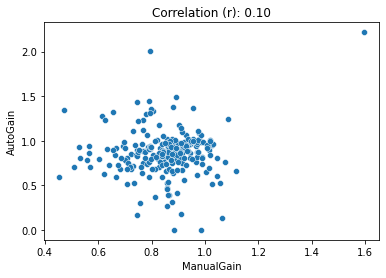

In [169]:
correlation_coef = AllSpeed['ManualGain'].corr(AllSpeed['AutoGain'])
# Create scatter plot
import seaborn as sns
import matplotlib.pyplot as plt
plot = sns.scatterplot(x='ManualGain', y='AutoGain', data=AllSpeed)
plot.set_title(f'Correlation (r): {correlation_coef:.2f}')

# Display the plot
plt.show()

### Bland-Altman plot

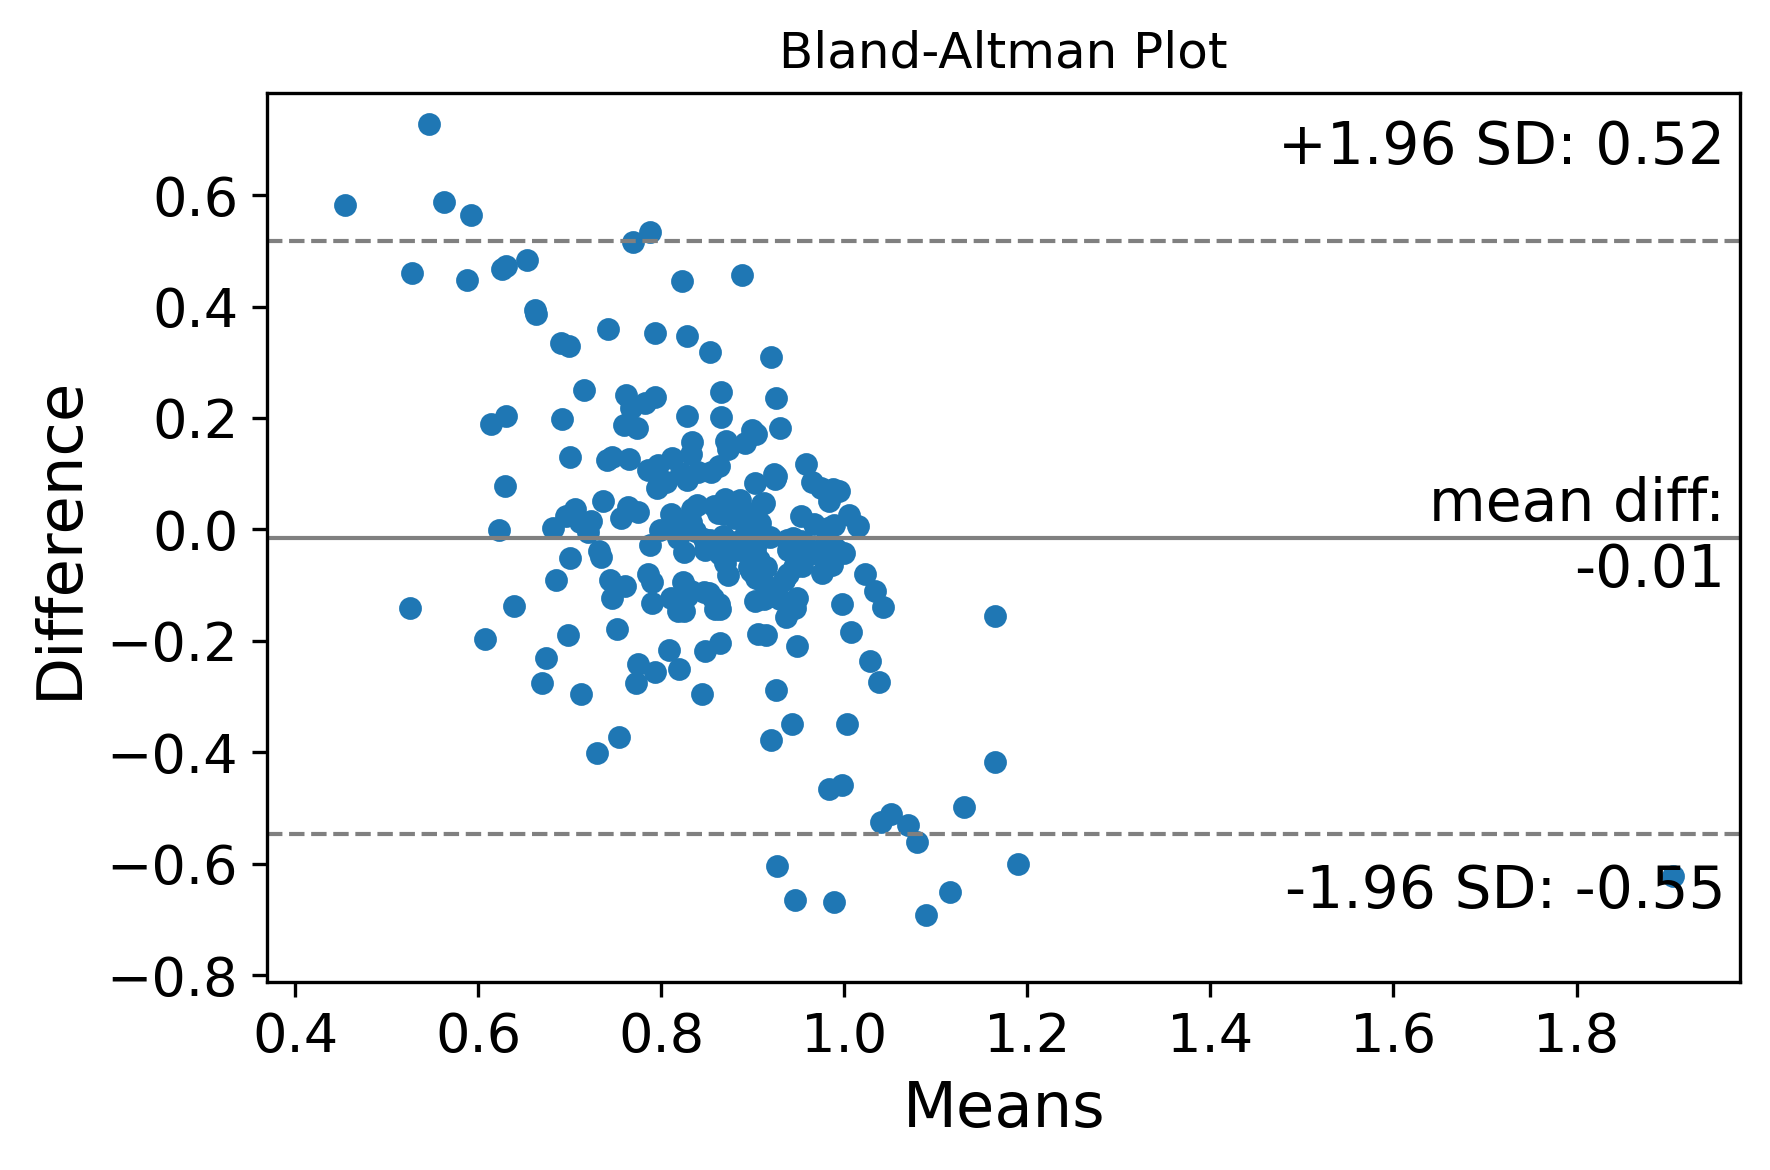

In [210]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

#create Bland-Altman plot       
# # Create a high-resolution figure
dpi = 300  # Adjust this value for your desired resolution
fig, ax = plt.subplots(dpi=dpi)           
#f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(AllSpeed.ManualGain, AllSpeed.AutoGain, ax = ax)
ax.set_title('Bland-Altman Plot')

# Adjust the margins to accommodate the entire figure
plt.tight_layout()

plt.savefig('BA_plot.jpeg', format='jpeg', dpi=300)

#display Bland-Altman plot
plt.show()


### Scatter Plot

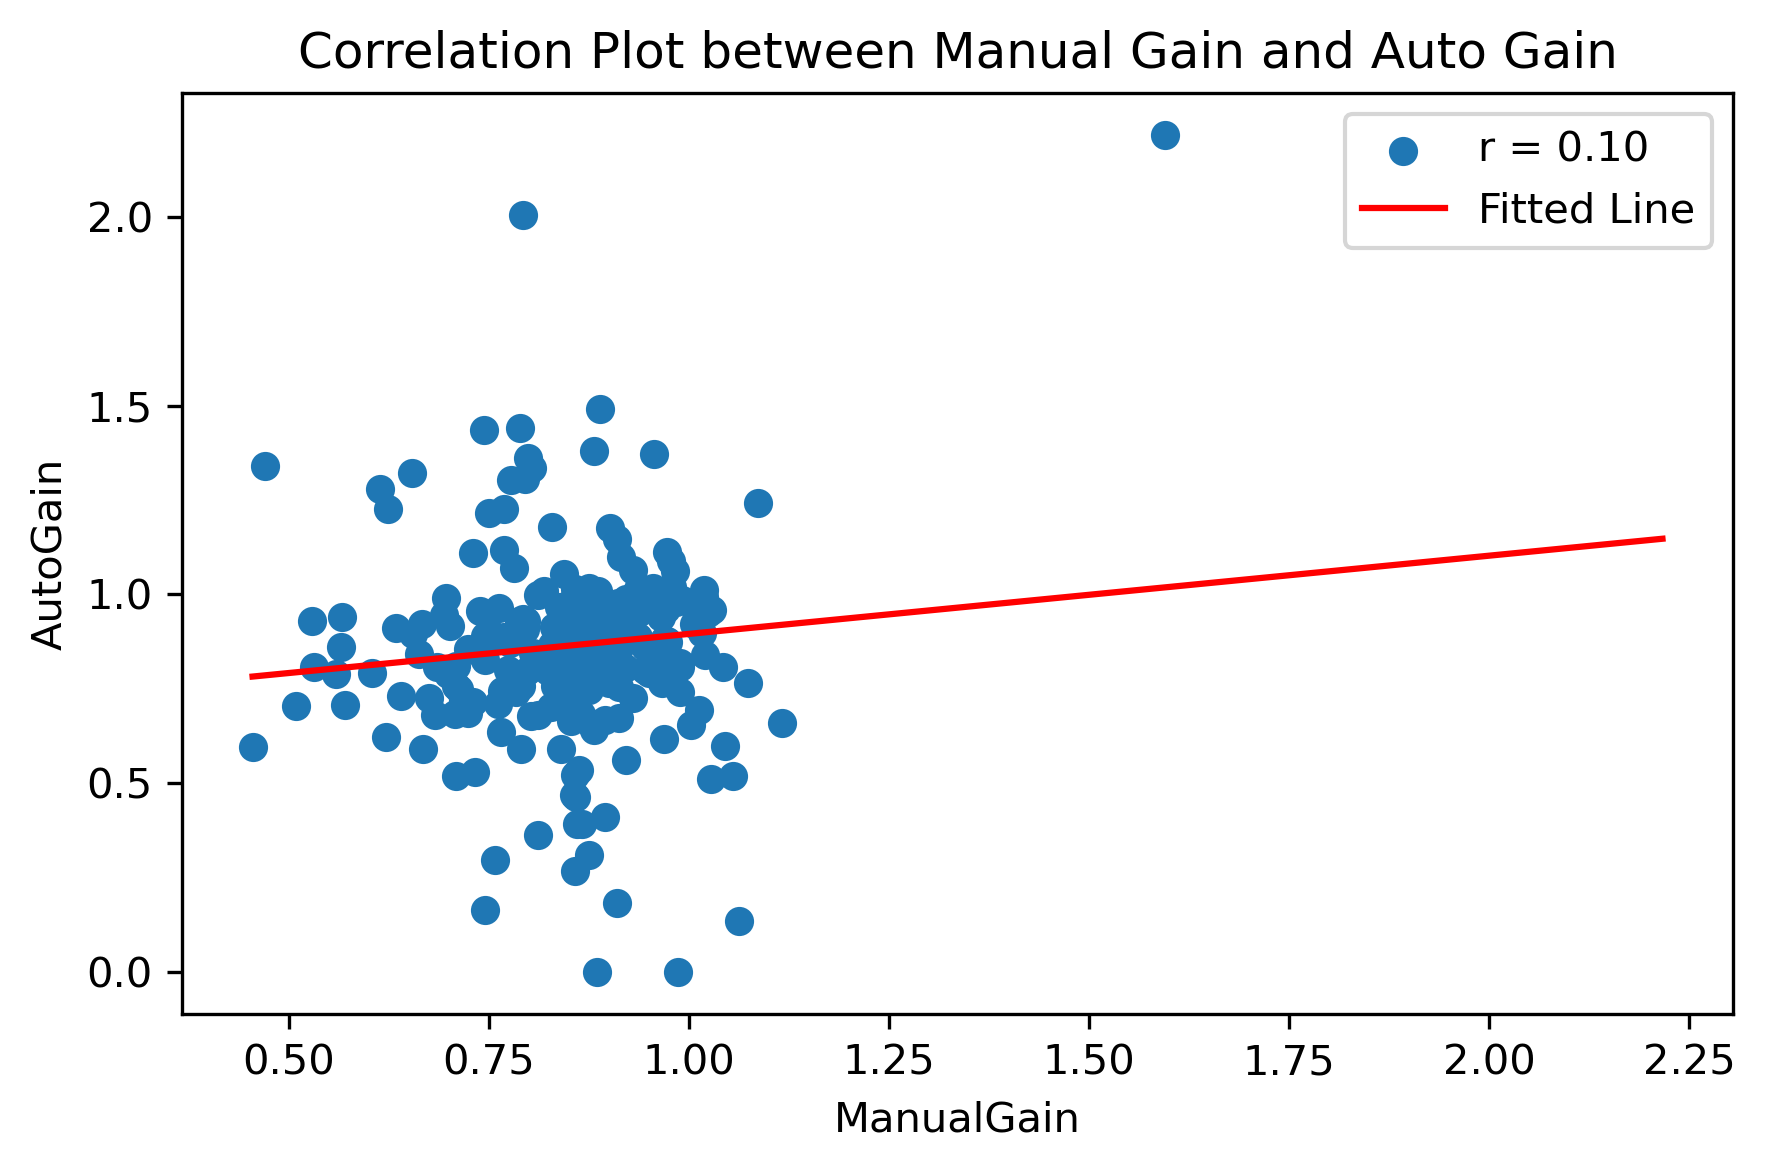

In [211]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np

# Assuming 'AllSpeed' is your DataFrame containing 'ManualGain' and 'AutoGain' columns

# Calculate Pearson correlation coefficient (r value) and p-value
r_value, p_value = pearsonr(AllSpeed['ManualGain'], AllSpeed['AutoGain'])

# Fit a linear model to the data
slope, intercept = np.polyfit(AllSpeed['ManualGain'], AllSpeed['AutoGain'], 1)
linear_model = lambda x: slope * x + intercept
x_fit = np.linspace(AllSpeed['ManualGain'].min(), AllSpeed['AutoGain'].max(), 100)
y_fit = linear_model(x_fit)

# Create a high-resolution scatter plot with the r value displayed and the fitted line
plt.figure(dpi=300)  # Increase the dpi value for higher resolution
plt.scatter(AllSpeed['ManualGain'], AllSpeed['AutoGain'], label=f'r = {r_value:.2f}')
plt.plot(x_fit, y_fit, color='red', label='Fitted Line')
plt.xlabel('ManualGain')
plt.ylabel('AutoGain')
plt.legend()
plt.title('Correlation Plot between Manual Gain and Auto Gain')

# Adjust the margins to accommodate the entire figure
plt.tight_layout()

# Save the figure in JPEG format
plt.savefig('corr_plot.jpeg', format='jpeg', dpi=300)
plt.show()


In [209]:
import pandas as pd
from scipy.stats import spearmanr


# Calculate the Spearman rank correlation coefficient and p-value
corr, pval = spearmanr(AllSpeed['ManualGain'], AllSpeed['AutoGain'])

# Print the correlation coefficient and p-value
print(f"Spearman's rank correlation coefficient: {corr}")
print(f"P-value: {pval}")

Spearman's rank correlation coefficient: 0.12311812481500002
P-value: 0.05428237646093961


### Correlation coefficient

In [189]:
import scipy.stats as stats
# Calculate the correlation coefficient
corr, _ = stats.pearsonr(AllSpeed['ManualGain'], AllSpeed['AutoGain'])

# Print the correlation coefficient
print(f"Correlation coefficient: {corr}")

Correlation coefficient: 0.10332843113401481


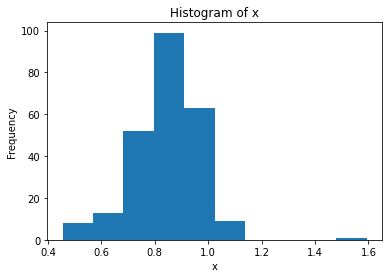

In [194]:

# Create a histogram
plt.hist(AllSpeed['ManualGain'], bins=10)

# Add axis labels and a title
plt.xlabel('x')
plt.ylabel('Frequency')
plt.title('Histogram of x')

# Show the plot
plt.show()

In [175]:
import statsmodels.api as sm
import pandas as pd


# Define the independent variable (X) and dependent variable (Y)
X = AllSpeed.AutoGain
Y = AllSpeed.ManualGain

# Add a constant term to the independent variable(s)
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(Y, X).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             ManualGain   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.622
Date:                Thu, 15 Jun 2023   Prob (F-statistic):              0.107
Time:                        00:25:59   Log-Likelihood:                 160.19
No. Observations:                 245   AIC:                            -316.4
Df Residuals:                     243   BIC:                            -309.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8054      0.029     28.071      0.0

### P value

In [212]:
import numpy as np
from scipy import stats
 
# Perform the two independent samples t-test
t_statistic, p_value = stats.ttest_ind(AllSpeed.ManualGain, AllSpeed.AutoGain)
 
# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)
 
# Set significance level (α)
alpha = 0.05
 
# Compare the p-value with the significance level
if p_value < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

T-statistic: -0.8064498703866002
P-value: 0.4203763308985795
Fail to reject the null hypothesis


In [171]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Calculate the mean difference and limits of agreement
mean_diff = AllSpeed['ManualGain'].mean() - AllSpeed['AutoGain'].mean()
std_diff = np.std(AllSpeed['ManualGain'] - AllSpeed['AutoGain'])
loa_upper = mean_diff + 1.96 * std_diff
loa_lower = mean_diff - 1.96 * std_diff

# Create the Bland-Altman plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=AllSpeed['ManualGain'],
    y=(AllSpeed['ManualGain'] - AllSpeed['AutoGain']),
    mode='markers',
    marker=dict(
        size=8,
        color='blue',
        symbol='circle',
        opacity=0.5
    ),
    name='ManualGain vs. AutoGain'
))

fig.add_trace(go.Scatter(
    x=[AllSpeed['ManualGain'].min(), AllSpeed['ManualGain'].max()],
    y=[mean_diff, mean_diff],
    mode='lines',
    line=dict(
        color='red',
        width=2,
        dash='dash'
    ),
    name=f'Mean difference ({mean_diff:.2f})'
))

fig.add_trace(go.Scatter(
    x=[AllSpeed['ManualGain'].min(), AllSpeed['ManualGain'].max()],
    y=[loa_upper, loa_upper],
    mode='lines',
    line=dict(
        color='green',
        width=2,
        dash='dash'
    ),
    name=f'Upper limit of agreement ({loa_upper:.2f})'
))

fig.add_trace(go.Scatter(
    x=[AllSpeed['ManualGain'].min(), AllSpeed['ManualGain'].max()],
    y=[loa_lower, loa_lower],
    mode='lines',
    line=dict(
        color='green',
        width=2,
        dash='dash'
    ),
    name=f'Lower limit of agreement ({loa_lower:.2f})'
))

fig.update_layout(
    title='Bland-Altman Plot',
    xaxis_title='ManualGain',
    yaxis_title='Difference (ManualGain - AutoGain)',
    showlegend=True,
    legend=dict(
        x=0.02,
        y=0.02,
        font=dict(size=10),
        bordercolor='black',
        borderwidth=1
    )
)

fig.show()

In [139]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from scipy.stats import pearsonr


# Calculate the mean difference and limits of agreement
mean_diff = AllSpeed['ManualGain'].mean() - AllSpeed['AutoGain'].mean()
std_diff = np.std(AllSpeed['ManualGain'] - AllSpeed['AutoGain'])
loa_upper = mean_diff + 1.96 * std_diff
loa_lower = mean_diff - 1.96 * std_diff

# Calculate the correlation coefficient
corr, _ = pearsonr(AllSpeed['ManualGain'], AllSpeed['AutoGain'])

# Create the Bland-Altman plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=AllSpeed['ManualGain'],
    y=(AllSpeed['ManualGain'] - AllSpeed['AutoGain']),
    mode='markers',
    marker=dict(
        size=8,
        color='blue',
        symbol='circle',
        opacity=0.5
    ),
    name='ManualGain vs. AutoGain'
))

fig.add_trace(go.Scatter(
    x=[AllSpeed['ManualGain'].min(), AllSpeed['ManualGain'].max()],
    y=[mean_diff, mean_diff],
    mode='lines',
    line=dict(
        color='red',
        width=2,
        dash='dash'
    ),
    name=f'Mean difference ({mean_diff:.2f})'
))

fig.add_trace(go.Scatter(
    x=[AllSpeed['ManualGain'].min(), AllSpeed['ManualGain'].max()],
    y=[loa_upper, loa_upper],
    mode='lines',
    line=dict(
        color='green',
        width=2,
        dash='dash'
    ),
    name=f'Upper limit of agreement ({loa_upper:.2f})'
))

fig.add_trace(go.Scatter(
    x=[AllSpeed['ManualGain'].min(), AllSpeed['ManualGain'].max()],
    y=[loa_lower, loa_lower],
    mode='lines',
    line=dict(
        color='green',
        width=2,
        dash='dash'
    ),
    name=f'Lower limit of agreement ({loa_lower:.2f})'
))

fig.update_layout(
    title=f'Bland-Altman Plot (r={corr:.2f})',
    xaxis_title='ManualGain',
    yaxis_title='Difference (ManualGain - AutoGain)',
    showlegend=True,
    legend=dict(
        x=0.02,
        y=0.02,
        font=dict(size=10),
        bordercolor='black',
        borderwidth=1
    )
)

fig.show()

### Get the datapoints

In [122]:
from sklearn.linear_model import LinearRegression

# Create a LinearRegression object
model = LinearRegression()

# Fit the linear regression model
X = AllSpeed['AutoGain'].values.reshape(-1, 1)
y = AllSpeed['ManualGain']
model.fit(X, y)

# Get the coefficients and intercept
slope = model.coef_[0]
intercept = model.intercept_

# Print the results
print(f"Slope: {slope}, Intercept: {intercept}")

Slope: 0.18927275112661218, Intercept: 0.7012822656024188


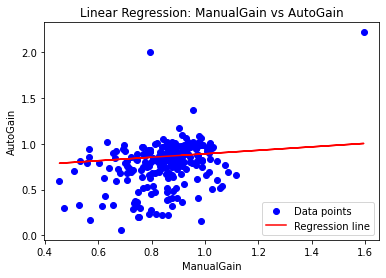

In [172]:
# Create a scatter plot of the data points
plt.scatter(X, y, color='blue', label='Data points')

# Plot the regression line
regression_line_x = X
regression_line_y = slope * regression_line_x + intercept
plt.plot(regression_line_x, regression_line_y, color='red', label='Regression line')

# Add labels and title
plt.xlabel('ManualGain')
plt.ylabel('AutoGain')
plt.title('Linear Regression: ManualGain vs AutoGain')

# Add legend
plt.legend()

# Show the plot
plt.show()

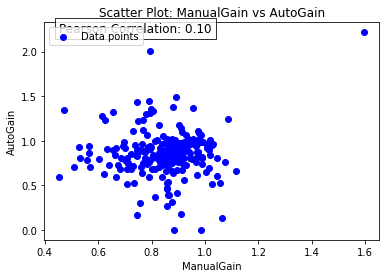

In [173]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# Fit the linear regression model
X = AllSpeed['ManualGain'].values.reshape(-1, 1)
y = AllSpeed['AutoGain']

# Calculate the Pearson correlation coefficient
correlation, p_value = stats.pearsonr(X.reshape(-1), y)

# Create a scatter plot of the data points
plt.scatter(X, y, color='blue', label='Data points')

# Add labels and title
plt.xlabel('ManualGain')
plt.ylabel('AutoGain')
plt.title('Scatter Plot: ManualGain vs AutoGain')

# Add legend
plt.legend()

# Add the Pearson correlation coefficient as text on the plot
correlation_text = f"Pearson Correlation: {correlation:.2f}"
plt.text(min(X), max(y), correlation_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# Show the plot
plt.show()